## Preprocessing

In [ ]:
# HELPERS
import helpers as h
import empatica_helpers as eh
import inquisit_helpers as ih

# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# ML IMPORTS
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# GLOBAL SETTINGS
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams["figure.figsize"] = (20, 10)
plt.style.use('seaborn-v0_8-notebook') # plt.style.use('ggplot'); print(plt.style.available)
pd.set_option('display.max_columns', None)

sr = 32
wl = 24 # Window length in seconds

# FULL PIPELINE
# --- Won't work because original data is not available ---
# e_raw, _ = eh.load_empatica(data_folder='input/empatica/', useIBI=False, save=True, plotTrimmings=False, desired_sampling_rate=sr)
# i_raw = ih.load_inquisit(data_folder='input/inquisit/', save=True)
# ei_raw = h.combine_empatica_and_inquisit(e_raw, i_raw, save=True, sr=sr)
# ei_prep = h.clean_and_filter(save=True, normalise=None, sr=sr, window_length=wl)
# --- Will work becasue ei_prep_original.csv is available ---
# X, y, p = h.prepare_for_vae(sr=sr, wl=wl, filepath="output/ei_prep_original.csv", save=False, normalise=None) # Normalisation now happens later in the process. Normalise = False applies the standard scaler to the data.
X_train, X_val, X_test, y_train, y_val, y_test, p_train, p_val, p_test = h.prepare_train_val_test_sets(filenames=['input/dl_X_wl24_sr32_original.pkl', 'input/dl_y_wl24_sr32_original.pkl', 'input/dl_p_wl24_sr32_original.pkl'])
X_train, X_val, X_test = h.handle_outliers_and_impute(X_train, X_val, X_test, num_mad=4, verbose=True)
X_train, X_val, X_test = h.scale_features(X_train, X_val, X_test, p_train, p_val, p_test, normalise=True)

## Data augmentation

### Model selection / hyperparemter optimisation

Resulted in the following file which contains the best parameters from the optimisation procedure: `240507_13 08_hyperopt_best_params.pkl`

In [ ]:
%run optimise_LSTM_VAE.py

**Print best parameters**

In [33]:
import pickle

# Defining hyperparameters
with open("input/240507_13 08_hyperopt_best_params.pkl", 'rb') as f:
    params = pickle.load(f)

# Define the choices for each parameter
choices = {
    'batch_size': [32, 64],
    'int_dim': [25, 50, 75, 100, 125, 150, 175, 200],
    'latent_dim': [7, 8, 10, 12, 14, 18, 24, 32, 48, 72, 96, 120],
    'reconstruction_wt': [1, 2, 3],
    'optimizer': ['Adam', 'RMSprop']
}

# Convert indices to actual parameter values
for param, choices in choices.items():
    params[param] = choices[params[param]]

print("BEST PARAMETERS:\n", params)


BEST PARAMETERS:
 {'batch_size': 32, 'int_dim': 50, 'latent_dim': 18, 'learning_rate': 0.0024794049759452375, 'optimizer': 'RMSprop', 'reconstruction_wt': 1, 'seed': 7235}


### Evaluation of synthetic data

Output is saved in `output/synth`:
- `240518_14 47_p_values.pkl`
- `240518_14 47_synthetic_samples.png` (Thesis: Figure 4)
- `240518_1558_for_each_frac_synth_ml_best_scores_(model.bs32.id50.ld18.lr0.002.rw1).pkl` (Thesis: Table 5)
- `240520_10 17_reconstructed_samples.png` (Thesis: Figure 5)
- `240520_10 17_samples_data.pkl` (Thesis: values in samples used for Figure 5)
- `240520_10 17_tsne_epoch54.png` (Thesis: Figure 7)

In [ ]:
%run evaluation_of_synthetic_data.py

**Kruskal-Wallis test with post-hoc correction**

In [35]:
with open("output/synth/240518_14 47_p_values.pkl", "rb") as f:
    p_values = pickle.load(f)

print(p_values)

{'p_values_0': [0.005018897480429772, 0.13287237210147299, 0.13465968365915812, 0.2852702777398367, 0.5214363125883961, 0.5349607498544209], 'p_values_0_corr': array([0.03011338, 0.26931937, 0.26931937, 0.42790542, 0.53496075,
       0.53496075]), 'p_values_1': [0.021695175778603932, 0.017388458771936868, 0.41200410136165744, 0.0016298372796895047, 0.29788660768881314, 0.7774457927602415], 'p_values_1_corr': array([0.04339035, 0.04339035, 0.49440492, 0.00977902, 0.44682991,
       0.77744579])}


## Training classification models

### Model selection / hyperparameter optimisation with cross-validation

Saved the best parameters per classifier and the balanced accuracy scores per cross-validation fold to:
- Best parameters: `output/240518_1558_ml_best_params_(model.bs32.id50.ld18.lr0.002.rw1).pkl`
- Best scores: `240518_1558_ml_best_scores_(model.bs32.id50.ld18.lr0.002.rw1).pkl`

In [ ]:
%run full_ml_optimisation_procedure.py 240507_1308_hyperopt_best_params.pkl

### Classifier Performance and Comparison

#### Retraining on train + val, evaluating on hold-out set

Saved the following files used for calculating evaluation metrics to:
- `output/ml/240519_1240_ml_confusion_matrices.pkl` 
- `output/ml/240519_1240_ml_evaluation_metrics.pkl` 
- `output/ml/240519_1240_ml_trained_models.pkl`

In [ ]:
%run retrain_ml_models_w_best_params.py

#### Obtaining plots for evaluating classifiers

**Paired samples t-test**

In [24]:
# Load 240517_0839_ml_best_scores_(model.bs32.id50.ld18.lr0.002.rw1).pkl
import pickle
import numpy as np 

with open('output/ml/240517_0839_ml_best_scores_(model.bs32.id50.ld18.lr0.002.rw1).pkl', 'rb') as f:
    scores = pickle.load(f)

# Print mean scores
for key, value in scores.items():
    print(f"Mean score for {key}: {np.mean(value)}")

# paired-differences t-test based on 10-fold cross-validation
from scipy.stats import ttest_rel

# Define the pairs exhaustively
pairs = [('xgb', 'svm'), ('xgb', 'glm'), ('xgb', 'rf'), ('svm', 'glm'), ('svm', 'rf'), ('glm', 'rf')]
# Perform the t-test for each pair
p_values = {pair: ttest_rel(scores[pair[0]], scores[pair[1]])[1] for pair in pairs}
print(p_values)

Mean score for xgb: 0.5429647014276393
Mean score for glm: 0.5398548546043902
Mean score for rf: 0.5100056454225375
Mean score for svm: 0.5484251026454063
{('xgb', 'svm'): 0.7961665624348254, ('xgb', 'glm'): 0.9216666428700022, ('xgb', 'rf'): 0.1552591583649316, ('svm', 'glm'): 0.8003946249502585, ('svm', 'rf'): 0.12280462267384527, ('glm', 'rf'): 0.2126467839388901}


**Print best model hyperparameters**

In [27]:
import pickle

with open("output/ml/240517_0839_ml_best_params_(model.bs32.id50.ld18.lr0.002.rw1).pkl", 'rb') as f:
    best_params = pickle.load(f)

print(best_params)

{'xgb': {'colsample_bylevel': 0.7310159899899309, 'colsample_bynode': 0.8819746159132799, 'colsample_bytree': 0.7378521271510112, 'fraction_synthetic': 0.1, 'gamma': 11.414144272275914, 'learning_rate': 0.008957308264875756, 'max_depth': 7, 'min_child_weight': 13.226976452477878, 'n_estimators': 959, 'objective': 'binary:logistic', 'reg_alpha': 9.767456781976513, 'reg_lambda': 13.352650839716745, 'scale_pos_weight': 2.024390243902439, 'subsample': 0.7824098762787712, 'window_size': 22}, 'glm': {'C': 0.012283286985130733, 'class_weight': 'balanced', 'fraction_synthetic': 0, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear', 'window_size': 8}, 'rf': {'class_weight': 'balanced', 'fraction_synthetic': 1.0, 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 119, 'window_size': 20}, 'svm': {'C': 9.8918988492138, 'class_weight': 'balanced', 'fraction_synthetic': 0.75, 'gamma': 0.07939563635683705, 'kernel': 'rbf', 'window_size': 22}

**Confusion matrices**

In [28]:
with open("output/ml/240519_1240_ml_confusion_matrices.pkl", "rb") as f:
    confusion_matrices = pickle.load(f)

print(confusion_matrices)

# Calculate TPR and FPR for each classifier
tpr = {}
fpr = {}
for key, value in confusion_matrices.items():
    tn, fp, fn, tp = value.ravel()
    tpr[key] = tp / (tp + fn)
    fpr[key] = fp / (fp + tn)

print("TPR: ", tpr)
print("FPR: ", fpr)

{'xgb': array([[56, 44],
       [20, 24]]), 'glm': array([[50, 50],
       [22, 22]]), 'rf': array([[99,  1],
       [44,  0]]), 'svm': array([[73, 27],
       [25, 19]])}
TPR:  {'xgb': 0.5454545454545454, 'glm': 0.5, 'rf': 0.0, 'svm': 0.4318181818181818}
FPR:  {'xgb': 0.44, 'glm': 0.5, 'rf': 0.01, 'svm': 0.27}


**Evaluation metrics**

{'xgb': {'balanced_accuracy': 0.5527272727272727, 'f1_score': 0.42857142857142855, 'auprc': 0.4334863302154337, 'auroc': 0.6145454545454544, 'roc_curve': (array([0.  , 0.  , 0.  , 0.02, 0.03, 0.05, 0.07, 0.07, 0.08, 0.08, 0.15,
       0.15, 0.18, 0.18, 0.19, 0.19, 0.2 , 0.2 , 0.24, 0.24, 0.25, 0.25,
       0.26, 0.26, 0.27, 0.27, 0.34, 0.34, 0.35, 0.37, 0.37, 0.4 , 0.4 ,
       0.44, 0.44, 0.45, 0.46, 0.46, 0.51, 0.51, 0.51, 0.52, 0.52, 0.53,
       0.55, 0.62, 0.65, 0.69, 0.7 , 0.7 , 0.72, 0.72, 0.73, 0.73, 0.73,
       0.75, 0.75, 0.79, 0.79, 0.82, 0.85, 0.88, 0.91, 0.93, 0.94, 0.97,
       0.99, 0.99, 1.  ]), array([0.        , 0.02272727, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.11363636, 0.11363636, 0.18181818,
       0.18181818, 0.20454545, 0.20454545, 0.22727273, 0.22727273,
       0.25      , 0.25      , 0.27272727, 0.27272727, 0.31818182,
       0.31818182, 0.34090909, 0.34090909, 0.36363636, 0.36363636,
       0.40909091, 0.40909091, 0.45454545, 0.

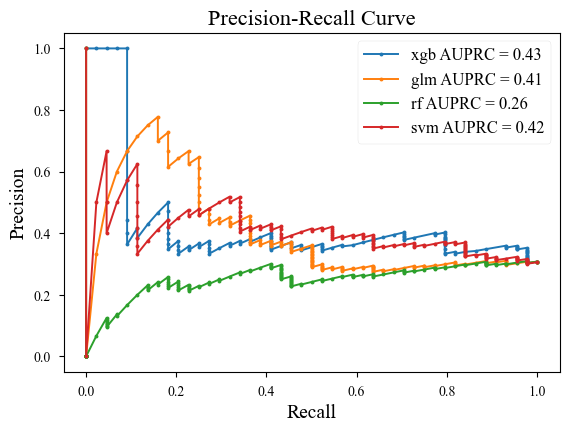

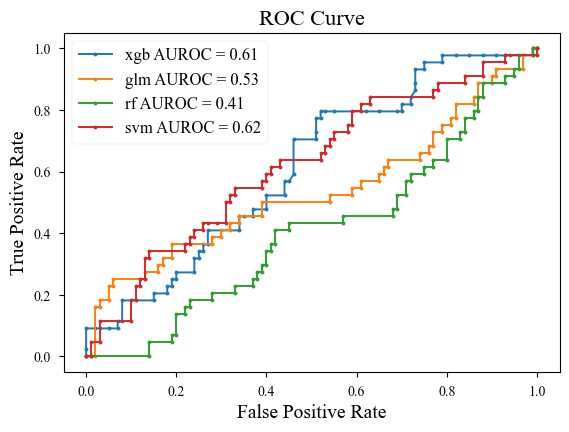

In [31]:
with open("output/ml/240519_1240_ml_evaluation_metrics.pkl", "rb") as f:
    evaluation_metrics = pickle.load(f)

print(evaluation_metrics)

import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["font.family"] = "Times New Roman"

# Plot AUPRC
for model_name, metrics in evaluation_metrics.items():
    precision, recall, _ = metrics['pr_curve']
    auprc_score = metrics['auprc']  # Assuming the AUPRC score is stored directly under 'auprc'
    plt.plot(recall, precision, marker='.', label=f'{model_name} AUPRC = {auprc_score:.2f}')

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Plot AUROC
for model_name, metrics in evaluation_metrics.items():
    fpr, tpr, _ = metrics['roc_curve']
    auroc_score = metrics['auroc']  # Assuming the AUROC score is stored directly under 'auroc'
    plt.plot(fpr, tpr, marker='.', label=f'{model_name} AUROC = {auroc_score:.2f}')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(fontsize=12)
# Set tick label size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
